[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aebtehaj/FTCEncoder/blob/main/Main.ipynb)


# **An Autoencoder Architecture for L-band Passive Microwave Retrieval of Freeze-Thaw Cycle**


<a class="anchor" id="0.1"></a>
# Table of Contents

[1. Introduction](#1) 

[2. Methodology](#2) 

[3. Construction of Training Data](#3) 

[4. Code](#4)

* [4.1 Setup](#41)

* [4.2 Load the Data](#42)

* [4.2 Preprocess the Data for Training](#43)

* [4.3 Create FTC Encoder Model](#44)

* [4.4 Training](#45)

* [4.5 Computing FT probability for SMAP TB](#46)


<a name="1"></a> <br>
## Introduction

This Jupyter Notebook presents computational implementation of the *FTC-Encoder*: A convolutional autoencoder deep learning framework for probabilistic characterization of the ground freeze-thaw (FT) dynamics to enhance our understanding of permafrost response to global warming and shifts in the high-latitude carbon cycle, using Soil Moisture Active Passive (SMAP) satellite brightness temperatures (TB) observations at L-band. While the results are presented for SMAP data, the framework can be generalized to other low-frequency passive microwave observations with negligible atmospheric attenuation. 

The proposed method recasts the FT-cycle passive microwave retrieval as an anomaly detection problem in which the peak winter (summer) represents the normal (anomaly) segments of the TB time series. This approach relies on (i) a supervised convolutional autoencoder architecture that incorporates the temporal information of the TB time series; (ii) produces a probability measure representing the state of the surface FT cycle, and (iii) only needs labels for frozen (peak winter) and thawed (peak summer) segments of time series, which can be provided with minimum uncertainty and almost no reliance on sparse ground-based observations.


<img src="images/Fig_01_schematic_fig_13.png"  width="800" />

<p align="center"><em>A schematic representation of the FTC-Encoder architecture. Both polarization channels of SMAP TBs and their differences (i.e., polarization signal) are used as inputs. The encoder block captures a low-dimensional latent space representation through a series of 1D convolution layers followed by ReLU activation functions and a dropout layer with 10% rate. The decoder block upsamples the latent space through a series of 1D transposed convolution layers, the ReLU activation functions, and dropout layers. The filter size is one week but the number of filters varies from 32 to 64 through the encoder and decoder blocks.</em></p>

<a name="2"></a> <br>
## Methodology

The FTC-Encoder relies on a contrastive loss function to probabilistically characterize the landscape FT cycle conditioned on different land-cover types.

For unsupervised learning, the loss function is typically organized as a sum of squared reconstruction errors:

$$
    \mathbb{L}_\theta(\mathbf{x}) = \| \mathbf{x}-D(E(\mathbf{x},\theta)) \|^2_2,
$$

where $\mathbf{x} = (x_1, x_2, \ldots, x_n)$ is the input time series, $E(\cdot)$ and $D(\cdot)$ are the encoder and decoder functions, $\|\cdot\|_2^2$ denotes $\ell_2$-norm, and $\theta$ represents a set of the trainable parameters.

For the FT-cycle problem, we can define the TB time series over the peak frozen winter as normal points expecting an autoencoder to produce large errors when the landscape is thawed (known anomalies), enabling FT-cycle retrievals. However, this approach often proves ineffective due to the low discriminative capability of the autoencoder, which can arise from similar latent representations of frozen and thawed states. To address these limitations, this study proposes a new convolutional supervised autoencoder framework leading to a probabilistic representation of the FT cycle without any subjective thresholding.

Suppose that we have a training dataset $\{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \ldots, (\mathbf{x}_n, y_n)\}$, where $\mathbf{x}_i \in \mathbb{R}^{n_c \times m_i}$ represents the $i$-th time series at $n_c$ channels with variable length $m_i$, $y_i \in \{0,1\}$ denotes its labels that is $y_i = 1$ for a fully frozen normal data point and $y_i = 0$ for fully thawed anomalous data points. Here we assume that the conditional probability of FT state $y_i$, given a TB time series $\mathbf{x}_i$, follows the Bernoulli distribution:
</p>

$$
p(y_i|\mathbf{x}_i) = [\eta_\theta(\mathbf{x}_i)]^{y_i} [1-\eta_\theta(\mathbf{x}_i)]^{1-y_i}
$$


where $\eta_\theta(\mathbf{x}_i) = e^{-\mathbb{L}_\theta(\mathbf{x}_i)}$ and ranges between 0 and 1. This assumption leads to the following negative log-likelihood function [Yamanaka et al., 2019]:


$$
-\log p_\theta(y_i|\mathbf{x}_i) = -y_i \log \eta_\theta(\mathbf{x}_i) - (1-y_i)\log\left[1-\eta_\theta(\mathbf{x}_i)\right] = y_i \mathbb{L}_\theta(\mathbf{x}_i) - (1-y_i) \log\left[1-e^{-\mathbb{L}_\theta(\mathbf{x}_i)}\right]
$$

This function represents a contrastive loss that attempts to minimize the reconstruction error $\mathbb{L}_\theta(\mathbf{x}_i)$ for fully frozen or normal $(y_i=1)$ time series while maximizing it for fully thawed or anomalous $(y_i=0)$ time series. The reason is that when $y_i=0$, the term $-\log\left[1-e^{-\mathbb{L}_\theta(\mathbf{x}_i)}\right]$ is monotonically decreasing as a function of the reconstruction loss $\mathbb{L}_\theta(\mathbf{x}_i) \ge 0$ and thus its minimization is equivalent to maximization of $\mathbb{L}_\theta(\mathbf{x}_i)$, providing a contrastive trade-off between the losses of normal and anomaly samples. In this representation, for the optimal parameters $\hat{\theta}$, $p(y_i=1|\mathbf{x}_i) = \eta_\theta(\mathbf{x}_i)$ denotes the probability that each point $\mathbf{x}_i$ belongs to a normal or frozen state, enabling a probabilistic retrieval.


<a name="3"></a> <br>
## Training Data

For training, the enhanced SMAP TB time series at 9 km resolution from 2015 to 2017, with a minimum continuous length of one week, are utilized over the peak frozen winters (thawed summers) as normal (anomalous) points. The time series labels are provided using the ERA5 reanalysis data. To that end, the TB time series of frozen winters (thawed summers) are isolated when the ERA5 topsoil and 2-m air temperatures are lower (greater) than 271 (275)K. The safety margin of 2 K ensures that the selected segments represent frozen or thawed ground conditions with a high probability, excluding shoulder seasons.  

We trained multiple FTC-Encoders for different land surface types and subgrid water fractions to implicitly account for the interrelated landscape structural and radiometric properties. This training strategy aims to group pixels with analogous structural and radiometric properties to pave the way for improved FT-cycle retrievals.

<a name="4"></a> <br>
## Code

To Run this notebook in Google Colab, clone this repository

In [ ]:
!git clone https://github.com/aebtehaj/FTCEncoder

In [ ]:
cd FTCEncoder

<a name="41"></a> <br>
###   Setup


In [11]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import importlib
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='tensorflow')

# Import classes and functions from utils_main
import utils_main
importlib.reload(utils_main)
from utils_main import DataPreprocessor, AutoencoderModel, contrastive_loss_function, train_model,  compute_train_val_accuracy, compute_accuracy, visualize_probability_time_series, Accuracy
tf.config.list_physical_devices('GPU')

[]

<a name="42"></a> <br>
 ### Load the Data


The training data comprises segments with varying sizes of normalized TB time series at horizontal and vertical polarization and their differences, representing peak frozen and thawed seasons.

In [12]:
# Load the training data

Data = np.load('Datasets/Training_dataset.npz', allow_pickle=True)
Train_winter = Data['Train_winter'] # frozen time series with variable lengths
Train_summer = Data['Train_summer'] # thawed time series with variable lengths

print('The number of frozen time series is:')
print('--------------------------------')
print(Train_winter.shape)
print('The number of thawed time series is:')
print('--------------------------------')
print(Train_summer.shape)
i=random.randrange(Train_winter.shape[1])
print(f"The size of the {i}th traning data block in winter is:")
print('--------------------------------')
print(Train_winter[0,i].shape)

The number of frozen time series is:
--------------------------------
(1, 9380)
The number of thawed time series is:
--------------------------------
(1, 13397)
The size of the 8876th traning data block in winter is:
--------------------------------
(3, 164)


**Preparing data to train the model over Savannas land cover type**


<div style="text-align: center;">
    <img src="images\Fig_06_spatial_map_03.png" alt="Training for Savannas land cover type" width="300"/>
    <p><em>The study area overlaid with IGBP land-cover types, water-fraction classes, and the spatial distribution of 34 available International Soil Moisture Stations (ISMN) ground stations used in this study.</em></p>
</div>

<a name="43"></a> <br>
### Data Preprocessing for Training


In [13]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Initialize DataPreprocessor
preprocessor = DataPreprocessor()

# Collect and preprocess data
# 1- croping and paddeing the data 
train_winter_pad, train_summer_pad = preprocessor.collect_data(Train_winter, Train_summer)
# 2- appending the lables to the traning data and concatenate winter and summer data
print("number of squences x lengths of padded sequences x number of channels + lables")
print("------------------------------------------------------------------------------")
combine_train_set, Xytrain = preprocessor.create_master_train_data(train_winter_pad, train_summer_pad)


number of squences x lengths of padded sequences x number of channels + lables
------------------------------------------------------------------------------
(22777, 292, 4)


 <a name="44"></a> <br>

 ###   Create FTC-Encoder Model


In [14]:
# Model parameters
fs = 32                 # Specify the number of 1-D convolution filters 
ks = 8                  # Specify 1-D convolution filter size
dr = 0.1                # Specify the drop out rate

# Create and compile the autoencoder model
FTC_Encoder = AutoencoderModel(dropout_rate=dr, filter_size=fs, kernel_size=ks, l2_reg_rate=0.001)
model = FTC_Encoder.get_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=contrastive_loss_function, metrics = [Accuracy])
model.summary()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combine_train_set, Xytrain, test_size=0.2, random_state=1)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 3)]         0         
                                                                 
 masking_1 (Masking)         (None, None, 3)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          1600      
                                                                 
 batch_normalization_4 (Bat  (None, None, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          16416     
                                                       

<a name="45"></a> <br>

### Training FTC-Encoder Model


In [15]:
# Training the model
history = train_model(model, X_train, y_train, X_test, y_test, epochs = 10)

Epoch 1/10
285/285 [==============================] - 10s 31ms/step - loss: 2156.0081 - Accuracy: 93.6237 - val_loss: 2142.1250 - val_Accuracy: 89.8184
Epoch 2/10
285/285 [==============================] - 10s 34ms/step - loss: 2148.1160 - Accuracy: 97.3605 - val_loss: 2122.4612 - val_Accuracy: 98.0424
Epoch 3/10
285/285 [==============================] - 9s 32ms/step - loss: 2146.6653 - Accuracy: 98.0107 - val_loss: 2121.2415 - val_Accuracy: 98.6126
Epoch 4/10
285/285 [==============================] - 9s 33ms/step - loss: 2145.9104 - Accuracy: 98.3173 - val_loss: 2120.8418 - val_Accuracy: 98.6072
Epoch 5/10
285/285 [==============================] - 10s 34ms/step - loss: 2145.1650 - Accuracy: 98.5798 - val_loss: 2122.1228 - val_Accuracy: 98.1898
Epoch 6/10
285/285 [==============================] - 10s 34ms/step - loss: 2144.8357 - Accuracy: 98.7333 - val_loss: 2120.6492 - val_Accuracy: 98.9491
Epoch 7/10
285/285 [==============================] - 10s 36ms/step - loss: 2144.6392 - Ac

#### Evaluate the Trained Model on the Test Set


In [16]:
training_accuracy, testing_accuracy = compute_train_val_accuracy(
    model, X_train, y_train, X_test, y_test
)

570/570 [==============================] - 3s 5ms/step
Training Accuracy: 99.18%
143/143 [==============================] - 1s 5ms/step
Testing Accuracy: 98.98%


<a name="46"></a> <br>

### FT Probability Computation with FTC-Encoder using SMAP TB Time Series


Load SMAP TB time series for 2018-2019 along with additional parameters including ground and air temperatures from ERA5.


In [17]:
Data_SMAP = np.load('Datasets/Testing_dataset_SMAP_ts.npz', allow_pickle=True)
normalized_ts = Data_SMAP['normalized_ts']
SMAP_ts = Data_SMAP['SMAP_ts']
var_ts = Data_SMAP['var_ts']

In [18]:
# Compute the probability of FT state using FTC-Encoder
processed_test_data = preprocessor.process_test_data(normalized_ts)
reconstruction = model.predict(processed_test_data)
test_mae_loss_winter = np.sqrt(np.mean(np.square(reconstruction - processed_test_data), axis=2))
mse = np.mean(np.square(reconstruction - processed_test_data) , axis = 2)
prob = 1-np.exp(-mse)

47/47 [==============================] - 0s 7ms/step


 ####   Plot the result


Accuracy: 96.70%


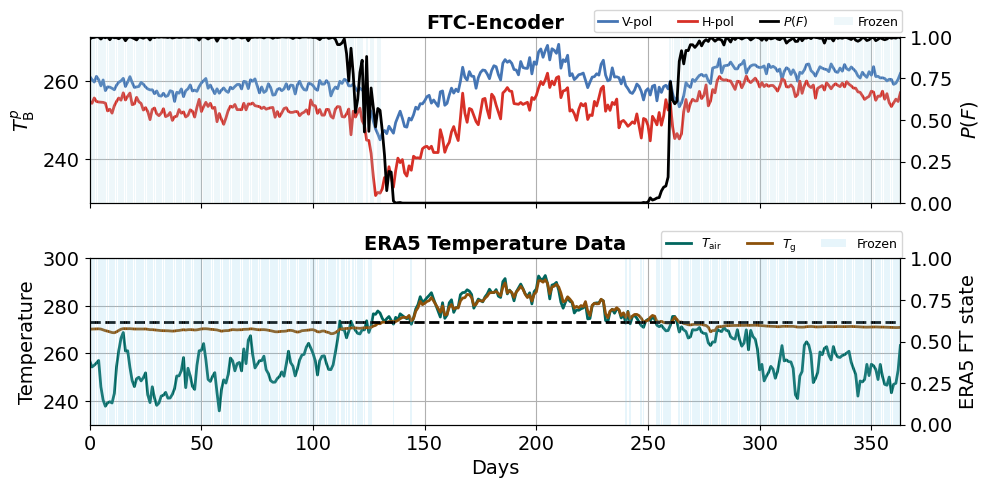

In [19]:
n = 50  # The index of the data sample to be visualized (Max 1500)
visualize_probability_time_series(n, SMAP_ts, prob, var_ts, fs = 14, start_timeid=1, end_timeid=365)
